Number of contours detected: 31
Detected hair widths (in pixels): [8.449186325073242, 662.1223754882812, 5.641620635986328, 17.911026000976562, 11.459981918334961, 5.7044148445129395, 6.637933254241943, 10.651079177856445, 13.734341621398926, 5.773502826690674, 6.253483772277832, 23.460769653320312, 6.747386932373047, 5.10950231552124, 7.557150840759277, 5.773502826690674, 54.839168548583984, 28.937822341918945, 29.48271942138672, 15.631978034973145, 20.850284576416016, 7.066035747528076, 7.955206871032715, 10.833650588989258, 21.708744049072266, 25.830339431762695, 115.81079864501953]
Detected hair widths (in mm): [2.196788444519043, 172.15181762695312, 1.4668213653564455, 4.656866760253906, 2.97959529876709, 1.4831478595733643, 1.7258626461029054, 2.769280586242676, 3.570928821563721, 1.5011107349395751, 1.6259057807922364, 6.099800109863281, 1.7543206024169922, 1.3284706020355226, 1.964859218597412, 1.5011107349395751, 14.258183822631837, 7.523833808898926, 7.6655070495605475, 4.064

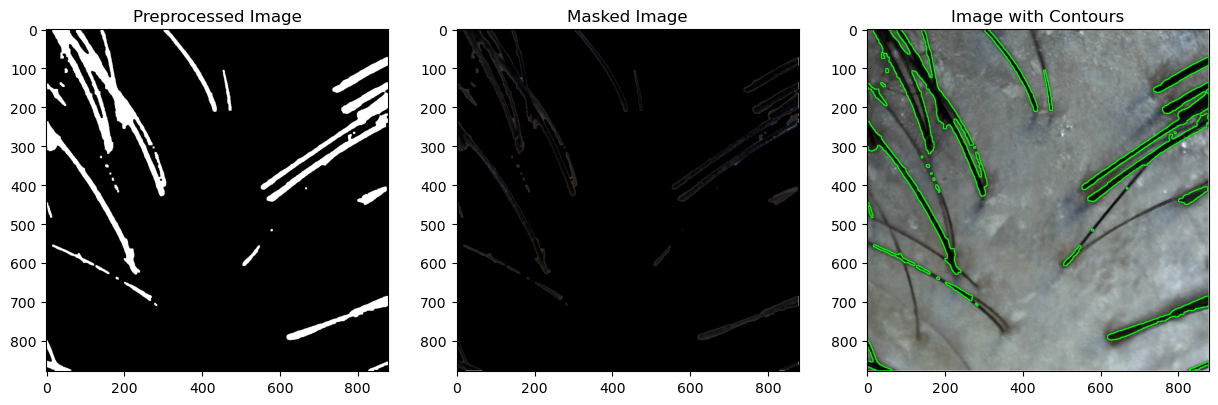

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_and_mask(image_path):
    
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
# PRE-PROCESSING:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# gaussian-blur
    blurred_img = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
# binary thresholding
    _, thresh_img = cv2.threshold(blurred_img, 50, 255, cv2.THRESH_BINARY_INV)
    
# morphological operations 
    kernel = np.ones((5, 5), np.uint8)
    morph_img = cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernel)
    morph_img = cv2.morphologyEx(morph_img, cv2.MORPH_OPEN, kernel)
    
# masking 
    masked_img = cv2.bitwise_and(img, img, mask=morph_img)
    
    return morph_img, masked_img, img

def calculate_widths(preprocessed_img):
    # Find contours in the preprocessed image
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("No contours found.")
    
    widths = []
    for contour in contours:
        if len(contour) >= 5:  # Ensure contour has enough points to fit an ellipse
            # Fit an ellipse to the contour and calculate the width
            ellipse = cv2.fitEllipse(contour)
            (x, y), (MA, ma), angle = ellipse
            width = min(MA, ma)  # Use the minor axis as the width
            widths.append(width)
    
    return widths, contours

def convert_pixels_to_mm(widths, pixel_to_mm_ratio):
    return [width * pixel_to_mm_ratio for width in widths]

def main(image_path):
    preprocessed_img, masked_img, original_img = preprocess_and_mask(image_path)
    

    widths_pixels, contours = calculate_widths(preprocessed_img)
    
    print(f"Number of contours detected: {len(contours)}")
    
    pixel_to_mm_ratio = 0.26  # 1 pixel = 0.26 mm
    widths_mm = convert_pixels_to_mm(widths_pixels, pixel_to_mm_ratio)
    
    print(f"Detected hair widths (in pixels): {widths_pixels}")
    print(f"Detected hair widths (in mm): {widths_mm}")
    
   
    img_with_contours = original_img.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Preprocessed Image')
    plt.imshow(preprocessed_img, cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title('Masked Image')
    plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 3)
    plt.title('Image with Contours')
    plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
    
    plt.show()

main('C:/Users/arthi/Downloads/WhatsApp Image 2024-08-07 at 8.34.24 PM.jpeg')
